# GroundingDINO + GPT-4 Vision

**NOTE:** ⚠️ This prompting pipeline is not yet natively supported by `multimodal-maestro`. Comming soon.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Dec  2 15:33:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

HOME = os.getcwd()
print(HOME)

/content


## Install Grounding DINO 🦕

In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 415 (delta 137), reused 125 (delta 122), pack-reused 237
Receiving objects: 100% (415/415), 12.85 MiB | 26.21 MiB/s, done.
Resolving deltas: 100% (214/214), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00


In [ ]:
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


## Download Grounding DINO Weights 🏋️

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


## Download Example Data

In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/uno.zip
!unzip uno.zip

/content
/content/data
Archive:  uno.zip
  inflating: IMG_7604.jpg            
  inflating: IMG_7601.jpg            
  inflating: IMG_7603.jpg            
  inflating: IMG_7600.jpg            
  inflating: IMG_7602.jpg            


## Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_image, load_model, predict

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Grounding DINO Demo

In [ ]:
from typing import Optional

import cv2
import numpy as np
import supervision as sv
import torch
from torchvision.ops import box_convert


def to_detections(image_source: np.ndarray, boxes: torch.Tensor) -> sv.Detections:
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    return sv.Detections(xyxy=xyxy)


def annotate(image_source: np.ndarray, detections: sv.Detections, labels: Optional[list[str]] = None) -> np.ndarray:
    box_annotator = sv.BoxAnnotator()
    annotated_frame = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
    return annotated_frame

In [ ]:
IMAGE_NAME = "IMG_7600.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "playing card"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, image=image, caption=TEXT_PROMPT, box_threshold=BOX_TRESHOLD, text_threshold=TEXT_TRESHOLD
)

detections = to_detections(image_source=image_source, boxes=boxes)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


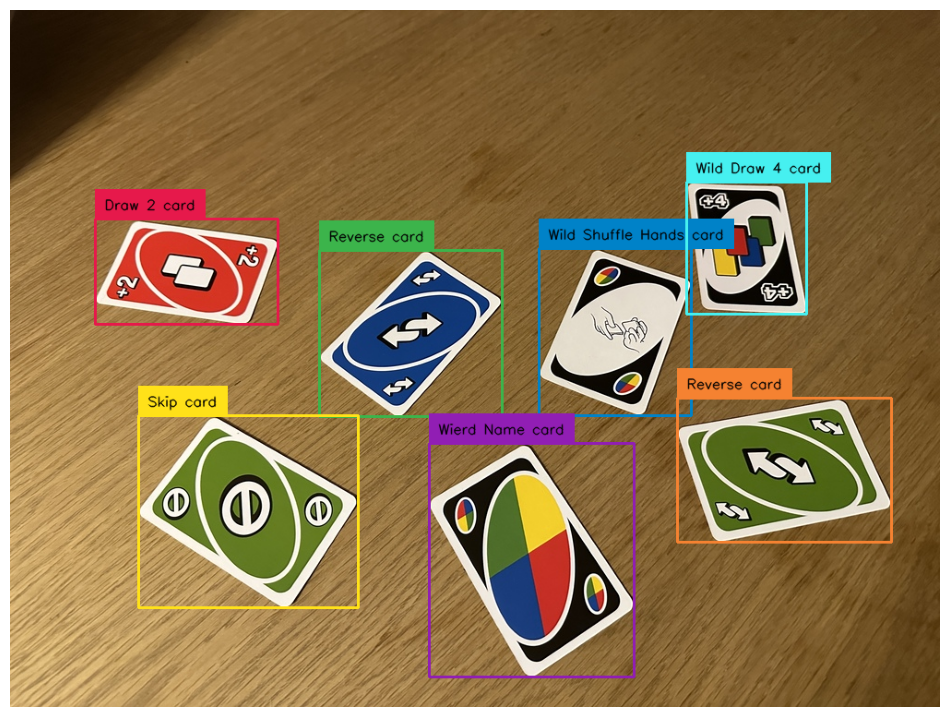

In [ ]:
labels = [
    "Draw 2 card",
    "Reverse card",
    "Skip card",
    "Wild Shuffle Hands card",
    "Reverse card",
    "Wierd Name card",
    "Wild Draw 4 card",
]
reference_image = annotate(image_source=image_source, detections=detections, labels=labels)
sv.plot_image(reference_image)

In [ ]:
IMAGE_NAMES = ["IMG_7601.jpg", "IMG_7602.jpg", "IMG_7603.jpg", "IMG_7604.jpg"]

In [ ]:
annotated_images = []
for image_name in IMAGE_NAMES:
    IMAGE_PATH = os.path.join(HOME, "data", image_name)

    TEXT_PROMPT = "playing card"
    BOX_TRESHOLD = 0.35
    TEXT_TRESHOLD = 0.25

    image_source, image = load_image(IMAGE_PATH)

    boxes, logits, phrases = predict(
        model=model, image=image, caption=TEXT_PROMPT, box_threshold=BOX_TRESHOLD, text_threshold=TEXT_TRESHOLD
    )

    detections = to_detections(image_source=image_source, boxes=boxes)

    labels = [str(i) for i in range(len(detections))]
    annotated_image = annotate(image_source=image_source, detections=detections, labels=labels)
    annotated_images.append(annotated_image)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


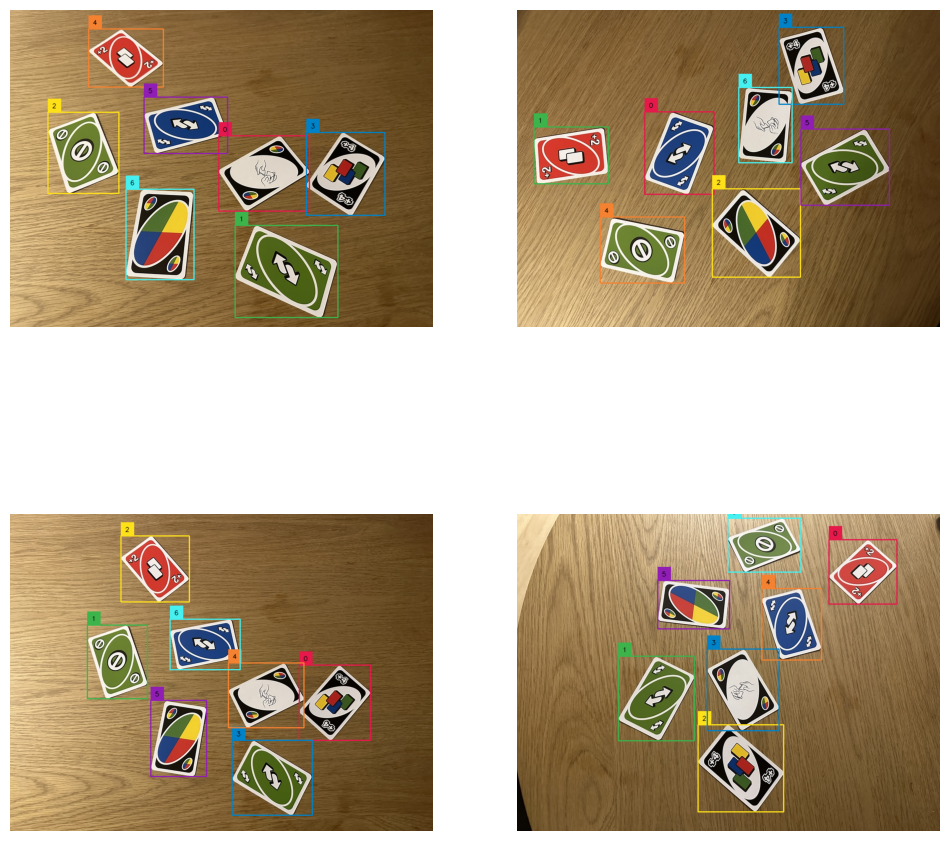

In [ ]:
sv.plot_images_grid(annotated_images, grid_size=(2, 2))

In [ ]:
OPENAI_API_KEY = "..."
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"

PROMPT = "The uploaded series of images is from a single video. "

In [ ]:
import base64

import requests


def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode(".jpg", image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode("utf-8")
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {"type": "text", "text": prompt}
    image_content = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"}}
        for image in images
    ]
    return {
        "model": "gpt-4-vision-preview",
        "messages": [{"role": "user", "content": [text_content, *image_content]}],
        "max_tokens": 300,
    }


def compose_headers(api_key: str) -> dict:
    return {"Content-Type": "application/json", "Authorization": f"Bearer {api_key}"}


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if "error" in response:
        raise ValueError(response["error"]["message"])
    return response["choices"][0]["message"]["content"]

In [ ]:
images = [reference_image, annotated_images[0]]

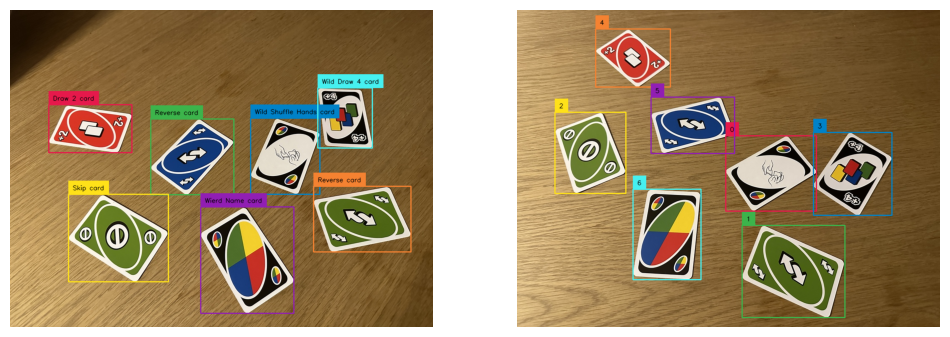

In [ ]:
sv.plot_images_grid(images, grid_size=(1, 2))

In [ ]:
prompt = (
    "I am sending you two photos. The objects in both photos are marked with "
    "bounding boxes and labeled. In the first one the labels contain the "
    "names of the object categories - the reference image, in the second one "
    "the labels are digits. Use the information in the first image and map "
    "the digits from the second photo to the corresponding object categories. "
    "Deliver them in JSON form, where the digit is the key and the category "
    "is the value."
)

print(prompt_image(api_key=OPENAI_API_KEY, images=images, prompt=prompt))

```json
{
  "1": "Reverse card",
  "2": "Skip card",
  "3": "Wild Shuffle Hands card",
  "4": "Draw 2 card",
  "5": "Reverse card",
  "6": "Weird Name card"
}
```
